In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from sentence_transformers import SentenceTransformer, util
import torch

In [7]:
df = pd.read_csv("FilesKG.csv")  
df.dropna(subset=['filename', 'file_type', 'description'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Loaded {len(df)} documents")

Loaded 142 documents


In [8]:
G = nx.DiGraph()

for _, row in df.iterrows():
    file_node = row['filename']
    file_type = row['file_type']
    
    G.add_node(file_node, type='file')
    G.add_node(file_type, type='category')
    G.add_edge(file_node, file_type, label='belongs_to')

In [ ]:
# Extract entities from description
def extract_entities(text):
    """
    Extract capitalized terms (as pseudo-entities)
    """
    entities = re.findall(r'\b[A-Z][a-zA-Z&()/.0-9-]+\b', str(text))
    return list(set(entities))

for _, row in df.iterrows():
    file_node = row['filename']
    entities = extract_entities(row['description'])
    for ent in entities:
        if len(ent) > 2 and not ent.isdigit():
            G.add_node(ent, type='entity')
            G.add_edge(file_node, ent, label='mentions')

In [ ]:
# Compute semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')
descriptions = df['description'].tolist()
embeddings = model.encode(descriptions, convert_to_tensor=True)

# Compute pairwise cosine similarity
cosine_scores = util.cos_sim(embeddings, embeddings)

In [ ]:
# Add “similar_to” edges for semantically related docs
threshold = 0.70  # tweakable

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        sim = cosine_scores[i][j].item()
        if sim > threshold:
            G.add_edge(df.iloc[i]['filename'], df.iloc[j]['filename'], label=f'similar_to ({sim:.2f})')

print(f"Graph created with {len(G.nodes())} nodes and {len(G.edges())} edges")

Graph created with 263 nodes and 2889 edges


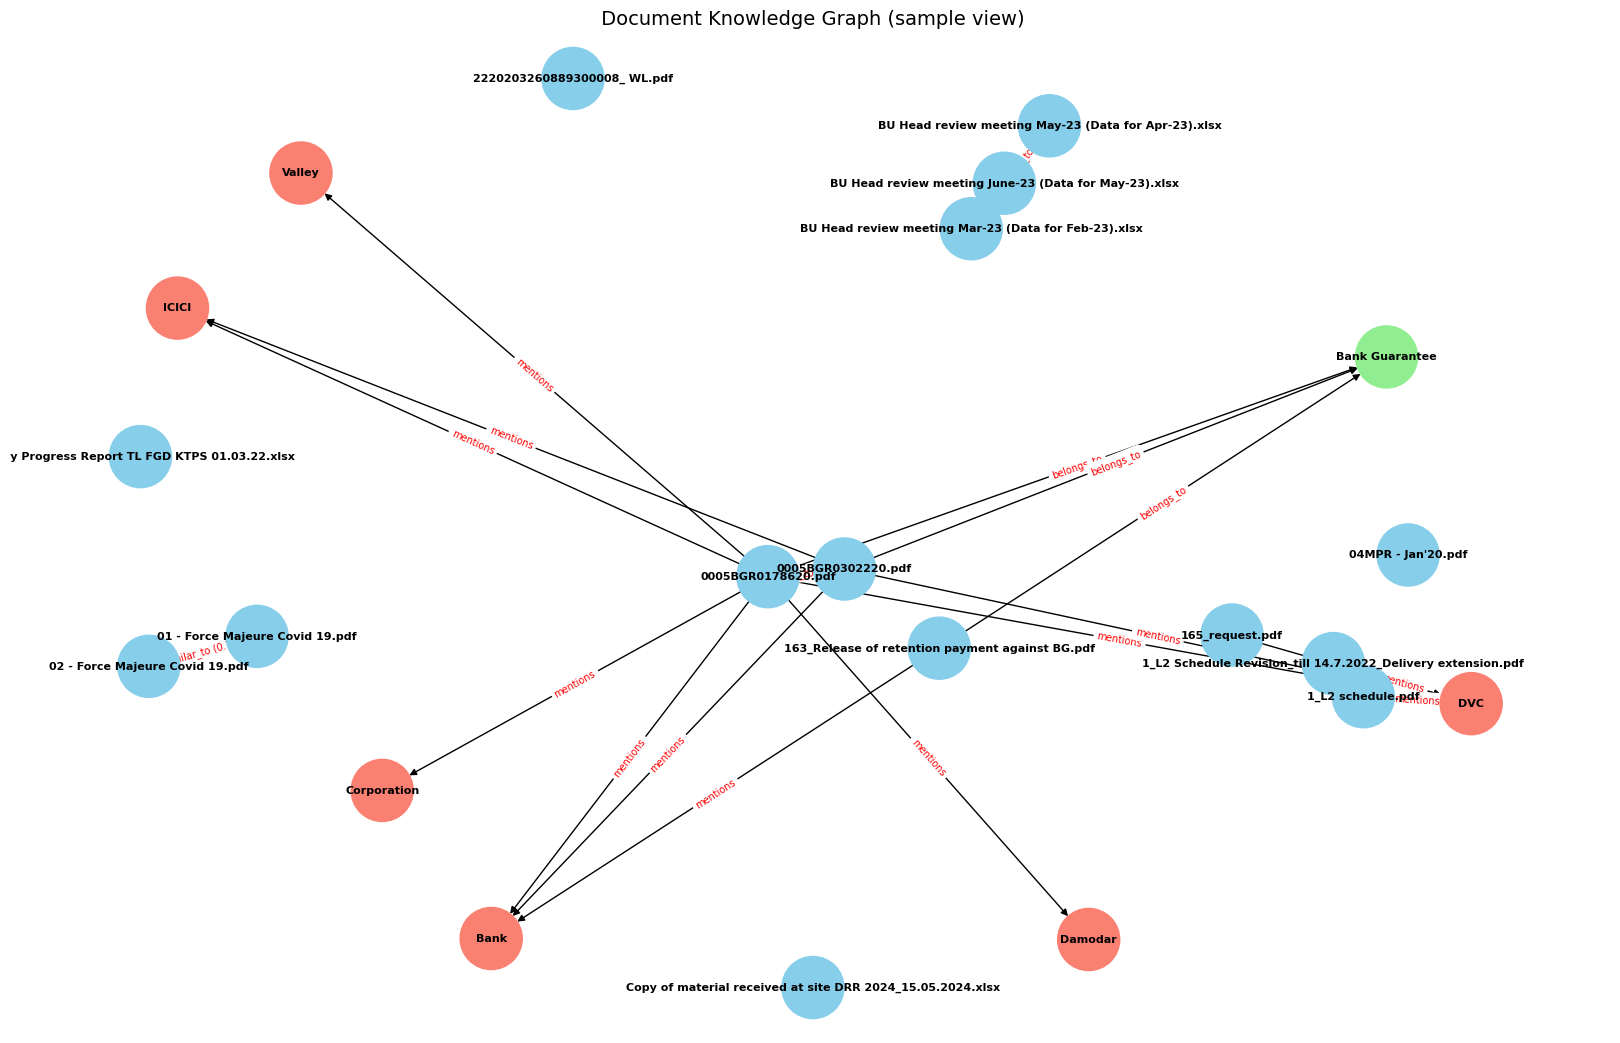

In [12]:
# Show only a subset to avoid clutter
sub_nodes = list(df['filename'][:15])  # show first 15 docs
subG = G.subgraph(sub_nodes + [n for n in G.neighbors(sub_nodes[0])])

plt.figure(figsize=(16, 10))
pos = nx.spring_layout(subG, seed=42)

# Color code nodes
colors = []
for node in subG:
    node_type = G.nodes[node].get('type', 'other')
    if node_type == 'file':
        colors.append('skyblue')
    elif node_type == 'category':
        colors.append('lightgreen')
    elif node_type == 'entity':
        colors.append('salmon')
    else:
        colors.append('grey')

nx.draw(subG, pos, with_labels=True, node_color=colors,
        node_size=2000, font_size=8, font_weight='bold', arrows=True)

edge_labels = nx.get_edge_attributes(subG, 'label')
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='red', font_size=7)

plt.title(" Document Knowledge Graph (sample view)", fontsize=14)
plt.show()

In [13]:
# Export graph as JSON for Neo4j or visualization tools
import json
from networkx.readwrite import json_graph

data = json_graph.node_link_data(G)
with open("knowledge_graph.json", "w", encoding='utf-8') as f:
    json.dump(data, f, indent=2)

print("✅ Exported as knowledge_graph.json")

c:\Users\Kaushik Mandal\.virtualenvs\KnowledgeGraph-82NpGr-d\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:145: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


✅ Exported as knowledge_graph.json
